# Midterm-Project: Walkability Accessment of Graz, Austria

Authors: Bernadette Kakuska, Clemens Wallisch, Elias Pfleger, Paul Badin

Course: GIS analysis techniques 2 (VU, WS25)

Date: 07/12/2025

> Kevic, K., Kuveždic Divjak, A., Zrno, K., and Vilicic, M. (2024). Open Data Supporting GIS-based Walkability Assessment: Case Study for City of Zagreb, Croatia, Int. Arch. Photogramm. Remote Sens. Spatial Inf. Sci., XLVIII-5-2024, 23–29, https://doi.org/10.5194/isprs-archives-XLVIII-5-2024-23-2024.

### Data Preparation

In [ ]:
# import libraries
import pandas as pd        
import numpy as np
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Polygon
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx   # for computing walking distances
import fiona   # for reading geospatial data
from keplergl import KeplerGl   # for Visualisation

import h3   # Hexagonal grid indexing for Spatial analysis

import rasterio
import rasterio.mask

Load the districts of Graz and merge them with the pop csv  (shp data converted in QGIS from Overpass)
(source of population data: Stadt Graz (2025). Zahlen + Fakten: Bevölkerung, Bezirke, Wirtschaft, Geografie. https://www.graz.at/cms/beitrag/10034466/7772565/Zahlen_Fakten_Bevoelkerung_Bezirke_Wirtschaft.html (Accessed December 2, 2025))

In [2]:
gdf_polygons = gpd.read_file("data/district_graz.geojson")
print(gdf_polygons.geom_type.value_counts())
print(gdf_polygons.head(3))
print(f"\nTotal numbers of districts: {len(gdf_polygons)}")

Polygon    17
Point      17
Name: count, dtype: int64
                id              @id @relations admin_level        boundary  \
0  relation/102537  relation/102537       None           9  administrative   
1  relation/102546  relation/102546       None           9  administrative   
2  relation/102553  relation/102553       None           9  administrative   

             name official_name postal_code ref:at:okz      type  wikidata  \
0    Innere Stadt          None        None      17453  boundary   Q250880   
1        Liebenau          None        None       None  boundary   Q876432   
2  Sankt Leonhard  St. Leonhard        None      17454  boundary  Q1530101   

                wikipedia                                           geometry  
0  de:Innere Stadt (Graz)  POLYGON ((15.44371 47.06706, 15.44372 47.06707...  
1      de:Liebenau (Graz)  POLYGON ((15.468 47.04249, 15.46799 47.04257, ...  
2  de:St. Leonhard (Graz)  POLYGON ((15.46177 47.06758, 15.46181 47.06761...  

Tot

In [3]:
gdf_districts = gdf_polygons[gdf_polygons.geom_type == "Polygon"]
print(gdf_districts.head(3))
print(f"\nTotal numbers of districts: {len(gdf_districts)}")

                id              @id @relations admin_level        boundary  \
0  relation/102537  relation/102537       None           9  administrative   
1  relation/102546  relation/102546       None           9  administrative   
2  relation/102553  relation/102553       None           9  administrative   

             name official_name postal_code ref:at:okz      type  wikidata  \
0    Innere Stadt          None        None      17453  boundary   Q250880   
1        Liebenau          None        None       None  boundary   Q876432   
2  Sankt Leonhard  St. Leonhard        None      17454  boundary  Q1530101   

                wikipedia                                           geometry  
0  de:Innere Stadt (Graz)  POLYGON ((15.44371 47.06706, 15.44372 47.06707...  
1      de:Liebenau (Graz)  POLYGON ((15.468 47.04249, 15.46799 47.04257, ...  
2  de:St. Leonhard (Graz)  POLYGON ((15.46177 47.06758, 15.46181 47.06761...  

Total numbers of districts: 17


             name                                           geometry
0    Innere Stadt  POLYGON ((15.44371 47.06706, 15.44372 47.06707...
1        Liebenau  POLYGON ((15.468 47.04249, 15.46799 47.04257, ...
2  Sankt Leonhard  POLYGON ((15.46177 47.06758, 15.46181 47.06761...
3         Geidorf  POLYGON ((15.42348 47.09566, 15.42338 47.09547...


<Axes: >

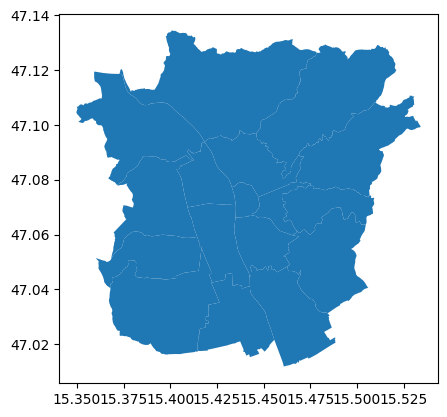

In [5]:
#extract the columns which are needed
gdf_districts = gdf_districts[["name", "geometry"]].copy()
print(gdf_districts.head(4))
gdf_districts.plot()

In [6]:
#loading csv with pop data of graz 
df_popgraz = pd.read_csv("data\Bevoelkerung Graz.csv", encoding="latin1", sep=";")
df_popgraz.head(18)

,Bezirk,Größe in km2,Einwohner,Einwohner pro km2
0,Innere Stadt,"1,16",3184,2745
1,Sankt Leonhard,"1,83",14692,8028
2,Geidorf,"5,5",23770,4322
3,Lend,"3,7",34308,9324
4,Gries,"5,05",30511,6042
5,Jakomini,"4,06",32114,7910
6,Liebenau,"7,99",16588,2076
7,Sankt Peter,"8,86",16615,1875
8,Waltendorf,"4,48",12432,2775
9,Ries,"10,16",6099,600


In [7]:
#merge the two datasets
gdf_districts_pop = gdf_districts.merge(df_popgraz, left_on="name", right_on="Bezirk")
gdf_districts_pop.head(3)

,name,geometry,Bezirk,Größe in km2,Einwohner,Einwohner pro km2
0,Innere Stadt,"POLYGON ((15.44371 47.06706, 15.44372 47.06707...",Innere Stadt,"1,16",3184,2745
1,Liebenau,"POLYGON ((15.468 47.04249, 15.46799 47.04257, ...",Liebenau,"7,99",16588,2076
2,Sankt Leonhard,"POLYGON ((15.46177 47.06758, 15.46181 47.06761...",Sankt Leonhard,"1,83",14692,8028


Get the POIs and merge them into one GDF

In [8]:
PLACE_NAME:str = "Graz, Austria"

                                    geometry category
element id                                           
node    251710886  POINT (15.43675 47.07188)   retail
        271624001  POINT (15.47242 47.05671)   retail
        278691038   POINT (15.4427 47.06992)   retail
        288172339  POINT (15.40841 47.07185)   retail
        290422098  POINT (15.45518 47.06741)   retail


<Axes: >

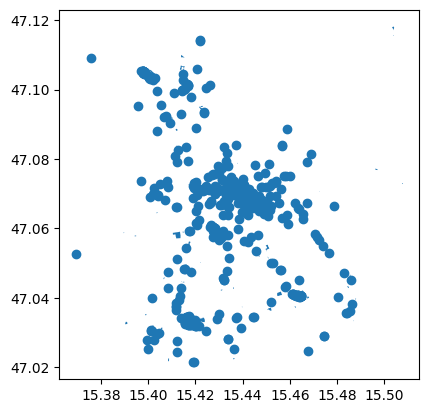

In [9]:
tags_retail = {
    "shop": [
        "clothes", "shoes", "furniture", "electronics", "computer",
        "mobile_phone", "kitchen", "houseware", "hardware", "doityourself",
        "books", "stationery", "jewelry", "boutique", "sports", "outdoor",
        "bicycle", "car", "car_repair", "motorcycle",
        "department_store", "mall", "variety_store", "general"
    ]
}

gdf_retail = ox.features_from_place(PLACE_NAME, tags_retail)
gdf_retail = gdf_retail[["geometry"]].copy()
gdf_retail["category"] = "retail"
print(gdf_retail.head(5))
gdf_retail.plot()


                                   geometry category
element id                                          
node    21015347  POINT (15.43238 47.02987)     food
        26899232  POINT (15.44826 47.07568)     food
        31611256   POINT (15.4581 47.06301)     food
        31620673   POINT (15.4342 47.02831)     food
        31620704  POINT (15.46442 47.03997)     food


<Axes: >

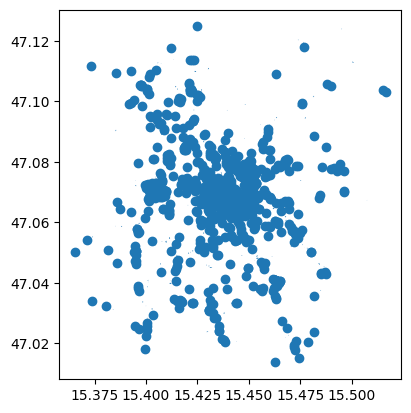

In [10]:
tags_food = {
    "amenity": [
        "supermarket", "marketplace", "greengrocer",
        "restaurant", "cafe", "fast_food", "ice_cream",
        "bar", "pub", "biergarten",
        "bakery"
    ],
    "shop": ["supermarket", "convenience", "greengrocer", "butcher", "seafood"]
}

gdf_food = ox.features_from_place(PLACE_NAME, tags_food)
gdf_food = gdf_food[["geometry"]].copy()
gdf_food["category"] = "food"
print(gdf_food.head(5))
gdf_food.plot()

                                    geometry       category
element id                                                 
node    31625435   POINT (15.43796 47.06991)  entertainment
        31625437      POINT (15.45 47.06382)  entertainment
        107935777  POINT (15.43765 47.04397)  entertainment
        251710896  POINT (15.44063 47.07142)  entertainment
        492011184  POINT (15.39263 47.07637)  entertainment


<Axes: >

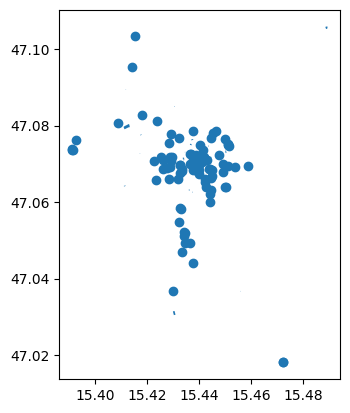

In [11]:
tags_entertainment = {
    "amenity": ["cinema", "theatre", "arts_centre", "nightclub", "casino"],
    "tourism": ["museum", "gallery"]
}

gdf_entertainment = ox.features_from_place(PLACE_NAME, tags_entertainment)
gdf_entertainment = gdf_entertainment[["geometry"]].copy()
gdf_entertainment["category"] = "entertainment"
print(gdf_entertainment.head(5))
gdf_entertainment.plot()

                                    geometry category
element id                                           
node    266657602  POINT (15.45089 47.06318)   office
        279089642  POINT (15.43966 47.07262)   office
        369490755  POINT (15.43934 47.06822)   office
        569570749  POINT (15.44646 47.07484)   office
        837234659  POINT (15.43417 47.05871)   office
<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 962 entries, ('node', np.int64(266657602)) to ('way', np.int64(1410449338))
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  962 non-null    geometry
 1   category  962 non-null    object  
dtypes: geometry(1), object(1)
memory usage: 57.9+ KB


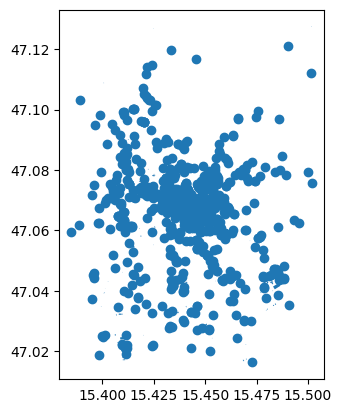

In [12]:
tags_office = {"office": True}
gdf_office = ox.features_from_place(PLACE_NAME, tags_office)
gdf_office = gdf_office[["geometry"]].copy()    
gdf_office["category"] = "office"
print(gdf_office.head(5))
gdf_office.plot()
gdf_office.info()

                                    geometry category
element id                                           
node    26899380   POINT (15.43737 47.06753)    civic
        26899638   POINT (15.46345 47.06607)    civic
        26899640   POINT (15.43932 47.06861)    civic
        117124121     POINT (15.483 47.0471)    civic
        269062537  POINT (15.41311 47.06663)    civic


<Axes: >

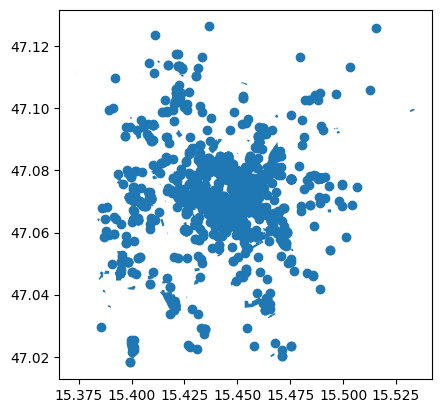

In [13]:
tags_civic = {
    "amenity": [
        "school", "university", "college",
        "hospital", "clinic", "doctors", "dentist",
        "police", "fire_station", "townhall",
        "library", "post_office", "courthouse"
    ]
}
gdf_civic = ox.features_from_place(PLACE_NAME, tags_civic)
gdf_civic = gdf_civic[["geometry"]].copy()
gdf_civic["category"] = "civic"
print(gdf_civic.head(5))
gdf_civic.plot()

                                    geometry category
element id                                           
node    197819750  POINT (15.45903 47.07323)    sport
        278113673  POINT (15.42145 47.07183)    sport
        291464359  POINT (15.45846 47.07323)    sport
        859421763  POINT (15.38524 47.09008)    sport
        940994980  POINT (15.42787 47.08845)    sport
<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 5427 entries, ('node', np.int64(197819750)) to ('way', np.int64(1452490981))
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  5427 non-null   geometry
 1   category  5427 non-null   object  
dtypes: geometry(1), object(1)
memory usage: 272.4+ KB


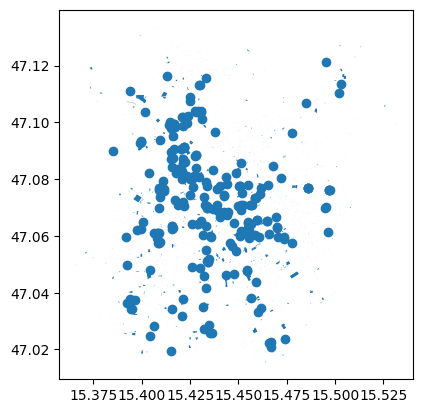

In [14]:
sport_tags = {
    "leisure": [
        "sports_centre", "pitch", "stadium", "swimming_pool", "fitness_centre",
        "playground", "miniature_golf"
    ],
}

gdf_sport = ox.features_from_place(PLACE_NAME, sport_tags)
gdf_sport = gdf_sport[["geometry"]].copy()
gdf_sport["category"] = "sport"
print(gdf_sport.head(5))
gdf_sport.plot()
gdf_sport.info()

In [15]:
#only point geometry for POIs
def only_points (gdf):
    gdf = gdf[["geometry", "category"]].copy()
    gdf = gdf.to_crs("EPSG:32633") #UTM zone 33N for Graz
    gdf['geometry'] = gdf.geometry.centroid
    gdf = gdf.to_crs("EPSG:4326") #back to WGS84
    gdf = gdf[gdf.geometry.type == "Point"].copy()
    gdf = gdf.reset_index(drop=True)
    return gdf

In [16]:
gdf_retail = only_points(gdf_retail)
gdf_food = only_points(gdf_food)
gdf_civic = only_points(gdf_civic)
gdf_sport = only_points(gdf_sport)
gdf_office = only_points(gdf_office)
gdf_entertainment = only_points(gdf_entertainment)

In [17]:
gdf_retail.head(3)

,geometry,category
0,POINT (15.43675 47.07188),retail
1,POINT (15.47242 47.05671),retail
2,POINT (15.4427 47.06992),retail


In [18]:
#final merge of all POI categories
gdf_pois = gpd.GeoDataFrame(pd.concat([gdf_retail, gdf_food, gdf_civic, gdf_sport, gdf_office, gdf_entertainment], ignore_index=True))
gdf_pois.info()
gdf_pois['category'].value_counts()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10146 entries, 0 to 10145
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  10146 non-null  geometry
 1   category  10146 non-null  object  
dtypes: geometry(1), object(1)
memory usage: 158.7+ KB


category
sport            5427
civic            1503
food             1403
office            962
retail            726
entertainment     125
Name: count, dtype: int64

Add Blues and Greens of Graz 

> Source: Copernicus Land Monitoring Service (n.d.). Urban Atlas Land Cover / Land Use 2018 (vector). https://land.copernicus.eu/en/products/urban-atlas/urban-atlas-2018 (Accessed December 2, 2025)

In [ ]:
layers = fiona.listlayers("data/AT002L3_GRAZ_UA2018_v013.gpkg")
print(layers)

['AT002L3_GRAZ_UA2018', 'AT002L3_GRAZ_UA2018_Boundary', 'AT002L3_GRAZ_UA2018_UrbanCore']


  country fua_name fua_code code_2018  \
0      AT     Graz  AT002L3     11220   
1      AT     Graz  AT002L3     11220   
2      AT     Graz  AT002L3     12100   

                                          class_2018 prod_date     identifier  \
0  Discontinuous medium density urban fabric (S.L...   2020-08   3208-AT002L3   
1  Discontinuous medium density urban fabric (S.L...   2020-08   6149-AT002L3   
2  Industrial, commercial, public, military and p...   2020-08  30126-AT002L3   

     perimeter           area comment  Pop2018  \
0   278.704449    4688.441889    None        9   
1  4009.964320  130449.086096    None      535   
2   309.287086    5366.132708    None        0   

                                            geometry  
0  MULTIPOLYGON (((4738225.83 2658159.675, 473830...  
1  MULTIPOLYGON (((4735000 2679302.11, 4734969.52...  
2  MULTIPOLYGON (((4770976 2678000.023, 4770982.5...  
  URAU_CODE FIRST_URAU FIRST_CNTR  SUM_POPL_2  \
0   AT002C1       Graz         AT       

<Axes: >

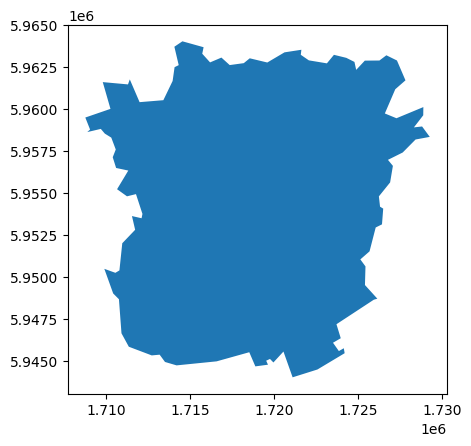

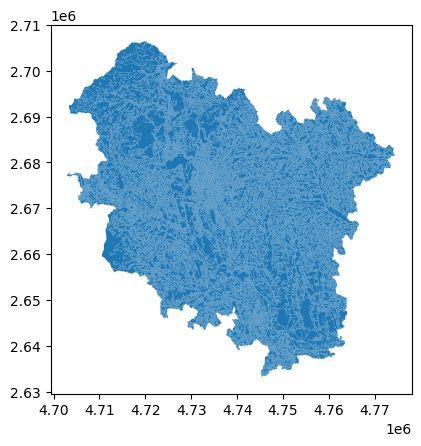

In [20]:
ua2018 = gpd.read_file("data/AT002L3_GRAZ_UA2018_v013.gpkg", layer="AT002L3_GRAZ_UA2018")
urban_core = gpd.read_file("data/AT002L3_GRAZ_UA2018_v013.gpkg", layer="AT002L3_GRAZ_UA2018_UrbanCore")
print(ua2018.head(3))
print(urban_core.head(3))

urban_core.plot()
ua2018.plot()

  country fua_name fua_code code_2018  \
0      AT     Graz  AT002L3     11220   
1      AT     Graz  AT002L3     11300   
2      AT     Graz  AT002L3     11220   

                                          class_2018 prod_date     identifier  \
0  Discontinuous medium density urban fabric (S.L...   2020-08   6149-AT002L3   
1                                Isolated structures   2020-08  25637-AT002L3   
2  Discontinuous medium density urban fabric (S.L...   2020-08   5707-AT002L3   

     perimeter           area comment  Pop2018 URAU_CODE FIRST_URAU  \
0  4009.964320  130449.086096    None      535   AT002C1       Graz   
1   273.919235    3555.472618    None        0   AT002C1       Graz   
2  6059.186788  196210.597575    None      496   AT002C1       Graz   

  FIRST_CNTR  SUM_POPL_2                                           geometry  
0         AT         0.0  POLYGON ((534403.308 5215305.559, 534403.002 5...  
1         AT         0.0  POLYGON ((535775.188 5217620.695, 535748.72

<Axes: >

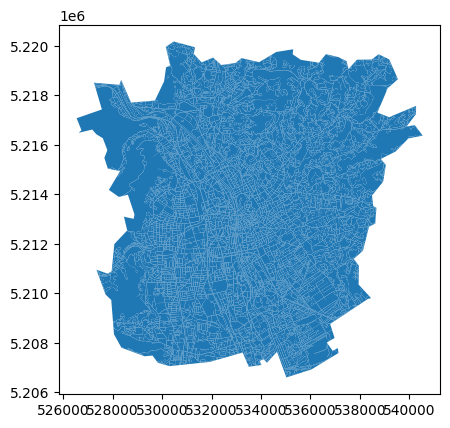

In [21]:
ua2018 = ua2018.to_crs(32633)
urban_core = urban_core.to_crs(32633)
ua_core = gpd.overlay(ua2018, urban_core, how="intersection")
print(ua_core.head(3))
ua_core.plot()

In [22]:
ua_core = ua_core.to_crs(4326)
ua_core["class_2018"].value_counts()

class_2018
Discontinuous medium density urban fabric (S.L. : 30% - 50%)    905
Discontinuous dense urban fabric (S.L. : 50% -  80%)            659
Industrial, commercial, public, military and private units      614
Discontinuous low density urban fabric (S.L. : 10% - 30%)       611
Pastures                                                        339
Continuous urban fabric (S.L. : > 80%)                          274
Arable land (annual crops)                                      161
Forests                                                         155
Green urban areas                                               152
Discontinuous very low density urban fabric (S.L. : < 10%)      128
Isolated structures                                             125
Sports and leisure facilities                                    90
Land without current use                                         74
Water                                                            25
Railways and associated land         

                                            geometry         class_2018  \
0  POLYGON ((15.47374 47.03472, 15.47244 47.03439...  Green urban areas   
1  POLYGON ((15.42144 47.06639, 15.42174 47.06652...  Green urban areas   
2  POLYGON ((15.4942 47.06416, 15.49478 47.06427,...  Green urban areas   

  code_2018  
0     14100  
1     14100  
2     14100  


<Axes: >

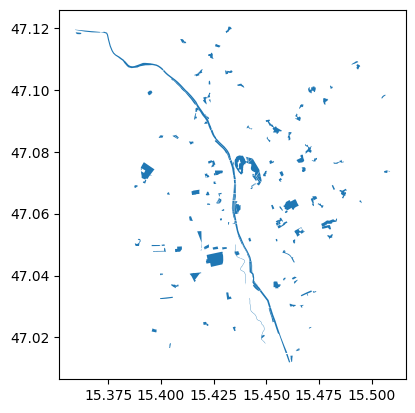

In [23]:
gdf_greens_blue = ua_core[ua_core["class_2018"].isin(["Green urban areas", "Water"])].copy()
gdf_greens_blue = gdf_greens_blue[["geometry", "class_2018", "code_2018"]].copy()
gdf_greens_blue = gdf_greens_blue.reset_index(drop=True)
print(gdf_greens_blue.head(3))
gdf_greens_blue.plot()

Get the walking network of Graz for routing


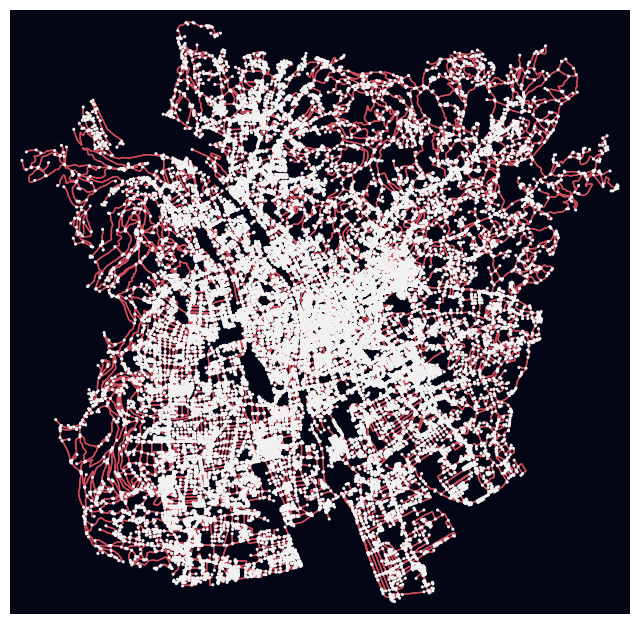

In [25]:
G = ox.graph_from_place(PLACE_NAME, network_type="walk")
G = ox.project_graph(G, to_crs = "EPSG:32633")
fig, ax = ox.plot_graph(G, node_size=5, bgcolor= "#040615", node_color='#f1f1f1', edge_color='#d44e5c')

### Analysis

Create H3-Grid

           name                                           geometry  \
0  Innere Stadt  POLYGON ((15.43705 47.07588, 15.43486 47.07135...   
1      Liebenau  POLYGON ((15.45699 47.05012, 15.4548 47.04559,...   
2      Liebenau  POLYGON ((15.45043 47.03654, 15.44824 47.03201...   
3      Liebenau  POLYGON ((15.45578 47.02079, 15.45359 47.01626...   
4      Liebenau  POLYGON ((15.44775 47.04441, 15.44557 47.03988...   

         Bezirk Größe in km2  Einwohner  Einwohner pro km2         h3_cells  
0  Innere Stadt         1,16       3184               2745  881e10a12bfffff  
1      Liebenau         7,99      16588               2076  881e10aac3fffff  
2      Liebenau         7,99      16588               2076  881e10aa8dfffff  
3      Liebenau         7,99      16588               2076  881e10aaabfffff  
4      Liebenau         7,99      16588               2076  881e10aac7fffff  


<Axes: >

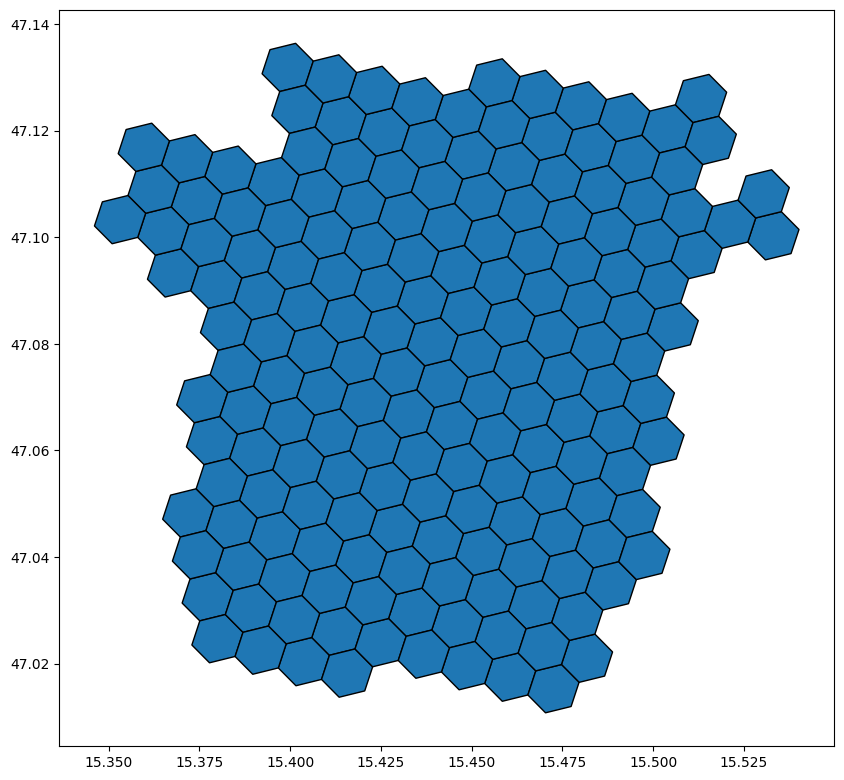

In [26]:
H3_RESOLUTION = 8  # Kevic et al. (2024) uses 500 m × 500 m square grid -> h3res=8 for Graz ~500m hexagons 

# function to convert a shapely polygon to H3 cells (v4 API)
def polygon_to_h3(polygon: Polygon, resolution=H3_RESOLUTION):
    """
    Converts a shapely Polygon to a list of H3 hex IDs.
    Works with H3 v4.x API.
    """
    # shapely uses (x=lon, y=lat), H3 expects (lat, lon)
    exterior = [(lat, lon) for lon, lat in polygon.exterior.coords]
    
    # handle interiors (holes)
    interiors = [[(lat, lon) for lon, lat in interior.coords] for interior in polygon.interiors]

    # create H3 LatLng polygon
    shape = h3.LatLngPoly(exterior, interiors)
    
    # get all H3 hexagons covering the polygon
    return list(h3.polygon_to_cells(shape, resolution))


# apply to all districts (use combined dataset)
gdf_districts_pop["h3_cells"] = gdf_districts_pop["geometry"].apply(polygon_to_h3)

# explode into one row per H3 cell for easier analysis
gdf_hex = gdf_districts_pop.explode("h3_cells").reset_index(drop=True)

# convert H3 cells to shapely polygons (v4.x API)
gdf_hex["geometry"] = gdf_hex["h3_cells"].apply(
    lambda cell: Polygon([
        (lon, lat) for lat, lon in h3.cell_to_boundary(cell)
    ])
)

# create geodataframe
gdf_hex = gpd.GeoDataFrame(gdf_hex, geometry="geometry", crs="EPSG:4326")

# Cleaning
gdf_hex = gdf_hex.drop_duplicates(subset='h3_cells', keep='first').reset_index(drop=True)

# check result
print(gdf_hex.head())
gdf_hex.plot(edgecolor="k", figsize=(10,10))

Connect POIs + H3

In [27]:
# --- Slope per hexagon from DEM raster ---
slope_raster_path = "data/DEM30_Graz.tif"

gdf_hex_utm = gdf_hex.to_crs("EPSG:32633").copy()
mean_slopes = []

with rasterio.open(slope_raster_path) as src:
    for _, row in gdf_hex_utm.iterrows():
        geom = [row.geometry.__geo_interface__]
        try:
            out_image, out_transform = rasterio.mask.mask(src, geom, crop=True)
            data = out_image[0]
            data = data[data != src.nodata]  # remove NoData
            if data.size > 0:
                mean_slope = float(data.mean())
            else:
                mean_slope = 0.0
        except ValueError:
            mean_slope = 0.0

        mean_slopes.append(mean_slope)

gdf_hex_utm["slope_deg"] = mean_slopes
gdf_hex = gdf_hex_utm.to_crs("EPSG:4326")


In [28]:
# Assign each POI to an H3 cel
def point_to_h3(point, res=H3_RESOLUTION):
    lat, lon = point.y, point.x
    return h3.latlng_to_cell(lat, lon, res)

gdf_pois["h3_cell"] = gdf_pois["geometry"].apply(point_to_h3)
# Now every POI has the H3 cell in which it lies.

In [29]:
# Prepare hex centroids (for distances)
gdf_hex["centroid"] = gdf_hex.geometry.centroid
gdf_hex["lat"] = gdf_hex.centroid.y
gdf_hex["lon"] = gdf_hex.centroid.x

C:\Users\cleam\AppData\Local\Temp\ipykernel_12100\212735153.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_hex["centroid"] = gdf_hex.geometry.centroid
C:\Users\cleam\AppData\Local\Temp\ipykernel_12100\212735153.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_hex["lat"] = gdf_hex.centroid.y
C:\Users\cleam\AppData\Local\Temp\ipykernel_12100\212735153.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_hex["lon"] = gdf_hex.centroid.x


In [30]:
# Build a nearest-POI lookup using pandas merge + groupby
pois_df = pd.DataFrame({
    "h3_cell": gdf_pois["h3_cell"],
    "poi_lat": gdf_pois.geometry.y,
    "poi_lon": gdf_pois.geometry.x,
    "category": gdf_pois["category"]
})

Compute distance to nearest POI per hex

In [31]:
# using haversine
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # meters
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))


# using the haversine, not reprojecting to UTM because haversine expects lat/lon

In [32]:
# compute minimum distance per hex × category
result = []

for cat in pois_df["category"].unique():
    subset = pois_df[pois_df["category"] == cat]

    # merge hex grid with POIs of this category
    merged = gdf_hex.merge(subset, how="cross")

    merged["distance_m"] = haversine(
        merged["lat"], merged["lon"],
        merged["poi_lat"], merged["poi_lon"],
    )

    # keep nearest POI
    nearest = merged.loc[
        merged.groupby("h3_cells")["distance_m"].idxmin(),
        ["h3_cells", "category", "distance_m"]
    ]

    result.append(nearest)

gdf_distances = pd.concat(result)
gdf_distances = gdf_distances.reset_index(drop=True)

print(gdf_distances.head())
print(gdf_distances.tail())
print(f"\nAmount: {len(gdf_distances)}")



          h3_cells category   distance_m
0  881e10a001fffff   retail  1165.183051
1  881e10a005fffff   retail   284.720878
2  881e10a007fffff   retail   920.492560
3  881e10a021fffff   retail  1100.783563
4  881e10a023fffff   retail  1288.845060
             h3_cells       category   distance_m
1057  881e10b8b9fffff  entertainment  1916.775165
1058  881e10b8bbfffff  entertainment  1408.312021
1059  881e10b8c3fffff  entertainment  4486.872705
1060  881e10b8d5fffff  entertainment  3557.591741
1061  881e10b8d7fffff  entertainment  2631.113038

Amount: 1062


Walking distances to the POIs

In [33]:
# Reproject hex centroids and POIs into EPSG:32633 to match CRS of street network
gdf_hex_utm = gdf_hex.to_crs("EPSG:32633")
gdf_hex_utm["centroid"] = gdf_hex_utm.geometry.centroid
gdf_hex_utm["x"] = gdf_hex_utm.centroid.x
gdf_hex_utm["y"] = gdf_hex_utm.centroid.y

gdf_pois_utm = gdf_pois.to_crs("EPSG:32633")
gdf_pois_utm["x"] = gdf_pois_utm.geometry.x
gdf_pois_utm["y"] = gdf_pois_utm.geometry.y

In [34]:
# Snap H3 centroids to nearest OSM nodes
gdf_hex_utm["osmid"] = ox.nearest_nodes(G, gdf_hex_utm["x"], gdf_hex_utm["y"])
print(gdf_hex_utm.head())

# Snap POIs to network
gdf_pois_utm["osmid"] = ox.nearest_nodes(G, gdf_pois_utm["x"], gdf_pois_utm["y"])
print("\n", gdf_pois_utm.head())



           name                                           geometry  \
0  Innere Stadt  POLYGON ((533179.629 5213688.708, 533016.36 52...   
1      Liebenau  POLYGON ((534710.569 5210834.642, 534547.304 5...   
2      Liebenau  POLYGON ((534220.75 5209322.578, 534057.462 52...   
3      Liebenau  POLYGON ((534637.339 5207575.517, 534474.043 5...   
4      Liebenau  POLYGON ((534012.486 5210195.978, 533849.201 5...   

         Bezirk Größe in km2  Einwohner  Einwohner pro km2         h3_cells  \
0  Innere Stadt         1,16       3184               2745  881e10a12bfffff   
1      Liebenau         7,99      16588               2076  881e10aac3fffff   
2      Liebenau         7,99      16588               2076  881e10aa8dfffff   
3      Liebenau         7,99      16588               2076  881e10aaabfffff   
4      Liebenau         7,99      16588               2076  881e10aac7fffff   

   slope_deg                        centroid        lat        lon  \
0        0.0  POINT (533551.084 52

In [35]:
# Compute walking distance to multiple nearest POIs for each category (using haversine)
walk_dist_list = []

# Define how many POIs needed per category
n_pois_per_category = {
    "retail": 3,
    "food": 3,
    "civic": 3,
    "entertainment": 2,
    "office": 1,
    "sport": 1
}

# Loop over categories
for cat_name in gdf_pois["category"].unique():
    
    # Get all POIs for this category
    cat_pois = gdf_pois[gdf_pois["category"] == cat_name].copy()
    n_needed = n_pois_per_category.get(cat_name, 1)
    
    # For each hex
    for idx, hex_row in gdf_hex.iterrows():
        hex_cell = hex_row["h3_cells"]
        hex_lat = hex_row["lat"]
        hex_lon = hex_row["lon"]
        
        # Calculate distance from hex centroid to all POIs of this category
        poi_lats = cat_pois.geometry.y.values
        poi_lons = cat_pois.geometry.x.values
        distances = haversine(hex_lat, hex_lon, poi_lats, poi_lons)
        
        # Get indices of n nearest POIs
        nearest_indices = np.argsort(distances)[:n_needed]
        nearest_distances = distances[nearest_indices]
        
        # Store each distance
        for dist in nearest_distances:
            walk_dist_list.append({
                "h3_cells": hex_cell,
                "category": cat_name,
                "distance_m_walk": dist
            })

# Create DataFrame
gdf_walk_distances = pd.DataFrame(walk_dist_list)
print("\nWalking distances calculated:")
print(gdf_walk_distances.head(20))
print(f"\nTotal rows: {len(gdf_walk_distances)}")
print(f"Rows per hex:")
print(gdf_walk_distances.groupby("h3_cells").size().describe())


Walking distances calculated:
           h3_cells category  distance_m_walk
0   881e10a12bfffff   retail        97.965238
1   881e10a12bfffff   retail       116.125633
2   881e10a12bfffff   retail       135.995651
3   881e10aac3fffff   retail       246.278854
4   881e10aac3fffff   retail       292.544201
5   881e10aac3fffff   retail       440.046418
6   881e10aa8dfffff   retail       482.801229
7   881e10aa8dfffff   retail       519.385571
8   881e10aa8dfffff   retail       676.968921
9   881e10aaabfffff   retail       962.130667
10  881e10aaabfffff   retail      1650.178165
11  881e10aaabfffff   retail      1673.484137
12  881e10aac7fffff   retail       208.466388
13  881e10aac7fffff   retail       223.524409
14  881e10aac7fffff   retail       244.979162
15  881e10aa81fffff   retail       579.193417
16  881e10aa81fffff   retail       594.829622
17  881e10aa81fffff   retail       715.733879
18  881e10aab9fffff   retail      1058.757861
19  881e10aab9fffff   retail      1059.733342

To

Define weighting for POIs (based on Kevic et al. 2024)

In [36]:
# create dicts for POIs categories
# Leisure perspective
weights_leisure = {
    "retail": [3, 1, 1],
    "food": [3, 1, 1],
    "entertainment": [3, 1],
    "office": [3],
    "civic": [3],
    "sport": [3]
}

# Daily obligations perspective
weights_daily = {
    "retail": [3, 1],
    "food": [3, 1],
    "entertainment": [3, 1],
    "office": [3, 1],
    "civic": [3, 1, 1],
    "sport": [3]
}


In [37]:
# Assign weights based on distance ranking
def poi_weights(df, weight_dict):
    """
    df: gdf_walk_distances (with columns h3_cells, category, distance_m_walk)
    weight_dict: dictionary of weights per category
    """
    df_weighted = df.copy()
    df_weighted["weight"] = 0  # initialize weight column

    for (hex_cell, cat_name), group in df_weighted.groupby(["h3_cells", "category"]):
        weights = weight_dict.get(cat_name, [1])  # default to 1 if category missing

        # Sort by distance (nearest first)
        sorted_indices = group.sort_values("distance_m_walk").index

        # Assign weights based on position (nearest gets first weight, etc.)
        for i, idx in enumerate(sorted_indices):
            if i < len(weights):
                df_weighted.loc[idx, "weight"] = weights[i]
            else:
                df_weighted.loc[idx, "weight"] = weights[-1]
    
    return df_weighted


Applying the POI weights function

In [38]:
# leisure perspective
gdf_walk_leisure = poi_weights(gdf_walk_distances, weights_leisure)
gdf_walk_leisure.head()

,h3_cells,category,distance_m_walk,weight
0,881e10a12bfffff,retail,97.965238,3
1,881e10a12bfffff,retail,116.125633,1
2,881e10a12bfffff,retail,135.995651,1
3,881e10aac3fffff,retail,246.278854,3
4,881e10aac3fffff,retail,292.544201,1


In [39]:
# daily obligations perspective
gdf_walk_daily = poi_weights(gdf_walk_distances, weights_daily)
gdf_walk_daily.head()

,h3_cells,category,distance_m_walk,weight
0,881e10a12bfffff,retail,97.965238,3
1,881e10a12bfffff,retail,116.125633,1
2,881e10a12bfffff,retail,135.995651,1
3,881e10aac3fffff,retail,246.278854,3
4,881e10aac3fffff,retail,292.544201,1


In [40]:
# checking results e.g. for distance ranking (single h3 cell and a category)
cell = "881e10a12bfffff"
category = "retail"

subset = gdf_walk_leisure[(gdf_walk_leisure["h3_cells"] == cell) & 
                           (gdf_walk_leisure["category"] == category)]
print(subset.sort_values("distance_m_walk"))


          h3_cells category  distance_m_walk  weight
0  881e10a12bfffff   retail        97.965238       3
1  881e10a12bfffff   retail       116.125633       1
2  881e10a12bfffff   retail       135.995651       1


In [41]:
# checking results e.g. Compare leisure vs daily weights (same h3 cell and category in leisure and daily obligations)
subset_leisure = gdf_walk_leisure[gdf_walk_leisure["h3_cells"] == cell]
subset_daily = gdf_walk_daily[gdf_walk_daily["h3_cells"] == cell]

print(subset_leisure)
print(subset_daily)

             h3_cells       category  distance_m_walk  weight
0     881e10a12bfffff         retail        97.965238       3
1     881e10a12bfffff         retail       116.125633       1
2     881e10a12bfffff         retail       135.995651       1
531   881e10a12bfffff           food        42.206298       3
532   881e10a12bfffff           food        97.126609       1
533   881e10a12bfffff           food       105.861494       1
1062  881e10a12bfffff          civic        74.336773       3
1063  881e10a12bfffff          civic        91.858686       3
1064  881e10a12bfffff          civic        95.530086       3
1593  881e10a12bfffff          sport       169.347476       3
1770  881e10a12bfffff         office        57.905629       3
1947  881e10a12bfffff  entertainment        31.439061       3
1948  881e10a12bfffff  entertainment        93.852249       1
             h3_cells       category  distance_m_walk  weight
0     881e10a12bfffff         retail        97.965238       3
1     88

In [42]:
# checking number of weights per category
gdf_walk_leisure.groupby("category")["weight"].value_counts()


category       weight
civic          3         531
entertainment  1         177
               3         177
food           1         354
               3         177
office         3         177
retail         1         354
               3         177
sport          3         177
Name: count, dtype: int64

Calculate accessibility scores

In [43]:
# Calculate accessibility scores (combining weight AND distance)

# Leisure perspective
gdf_walk_leisure["accessibility_contribution"] = gdf_walk_leisure["weight"] / (1 + gdf_walk_leisure["distance_m_walk"])

leisure_accessibility = gdf_walk_leisure.groupby("h3_cells")["accessibility_contribution"].sum().reset_index()
leisure_accessibility.rename(columns={"accessibility_contribution": "accessibility_score"}, inplace=True)

print("Leisure accessibility scores:")
print(f"Range: {leisure_accessibility['accessibility_score'].min():.4f} to {leisure_accessibility['accessibility_score'].max():.4f}")
print(f"Mean: {leisure_accessibility['accessibility_score'].mean():.4f}")


# Daily perspective
gdf_walk_daily["accessibility_contribution"] = gdf_walk_daily["weight"] / (1 + gdf_walk_daily["distance_m_walk"])

daily_accessibility = gdf_walk_daily.groupby("h3_cells")["accessibility_contribution"].sum().reset_index()
daily_accessibility.rename(columns={"accessibility_contribution": "accessibility_score"}, inplace=True)

print("\nDaily accessibility scores:")
print(f"Range: {daily_accessibility['accessibility_score'].min():.4f} to {daily_accessibility['accessibility_score'].max():.4f}")
print(f"Mean: {daily_accessibility['accessibility_score'].mean():.4f}")

Leisure accessibility scores:
Range: 0.0124 to 0.8818
Mean: 0.1408

Daily accessibility scores:
Range: 0.0110 to 0.8099
Mean: 0.1278


Environmental scores

In [44]:
# Environmental indicators
# Population density

#Cleaning
gdf_hex = gdf_hex.drop(columns=['hex_count', 'hex_count_x', 'hex_count_y', 'area_km2', 'area_km2_x', 'area_km2_y'], errors='ignore')

gdf_hex_area = gdf_hex.to_crs("EPSG:32633")  
gdf_hex_area["area_km2"] = gdf_hex_area.geometry.area / 1_000_000  # Convert m² to km²

# Count hex per district
hex_per_district = gdf_hex.groupby("name").size().reset_index(name="hex_count")
gdf_hex = gdf_hex.merge(hex_per_district, on="name", how="left")

# Population per hex
gdf_hex["pop_per_hex"] = gdf_hex["Einwohner"] / gdf_hex["hex_count"]

# Population density
gdf_hex = gdf_hex.merge(
    gdf_hex_area[["h3_cells", "area_km2"]], 
    on="h3_cells", 
    how="left"
)
gdf_hex["pop_density"] = gdf_hex["pop_per_hex"] / gdf_hex["area_km2"]

print(f"\nPopulation Density Statistics:")
print(f"  Range: {gdf_hex['pop_density'].min():.0f} to {gdf_hex['pop_density'].max():.0f} people/km²")
print(f"  Mean: {gdf_hex['pop_density'].mean():.0f} people/km²")
print(f"  Median: {gdf_hex['pop_density'].median():.0f} people/km²")


Population Density Statistics:
  Range: 548 to 11558 people/km²
  Mean: 2328 people/km²
  Median: 1720 people/km²


In [45]:
# Cleaning
gdf_hex = gdf_hex.drop(columns=['green_blue_pct', 'green_blue_pct_x', 'green_blue_pct_y'], errors='ignore')

# Green and blue spaces
gdf_hex_utm = gdf_hex.to_crs("EPSG:32633")
gdf_greens_blue_utm = gdf_greens_blue.to_crs("EPSG:32633")

# Calculate intersection of hex with green and blue spaces
green_blue_scores = []

for idx, hex_row in gdf_hex_utm.iterrows():
    hex_geom = hex_row.geometry
    hex_cell = hex_row["h3_cells"]
    hex_area = hex_geom.area
    
    intersecting = gdf_greens_blue_utm[gdf_greens_blue_utm.intersects(hex_geom)]
    
    if len(intersecting) > 0:
        # Calculate total intersection area
        total_green_blue_area = 0
        for _, green_row in intersecting.iterrows():
            intersection = hex_geom.intersection(green_row.geometry)
            total_green_blue_area += intersection.area
        
        # Calculate percentage
        green_blue_pct = (total_green_blue_area / hex_area) * 100
    else:
        green_blue_pct = 0
    
    green_blue_scores.append({
        "h3_cells": hex_cell,
        "green_blue_pct": green_blue_pct
    })

df_green_blue = pd.DataFrame(green_blue_scores)
gdf_hex = gdf_hex.merge(df_green_blue, on="h3_cells", how="left")

print(f"\nGreen/Blue Space Statistics:")
print(f"  Range: {gdf_hex['green_blue_pct'].min():.2f}% to {gdf_hex['green_blue_pct'].max():.2f}%")
print(f"  Mean: {gdf_hex['green_blue_pct'].mean():.2f}%")
print(f"  Hexagons with green/blue: {(gdf_hex['green_blue_pct'] > 0).sum()}")


Green/Blue Space Statistics:
  Range: 0.00% to 34.70%
  Mean: 2.92%
  Hexagons with green/blue: 99


Merge accessibility scores

In [46]:
gdf_hex = gdf_hex.merge(
    leisure_accessibility,
    on="h3_cells",
    how="left",
    suffixes=("", "_leisure")
)
gdf_hex.rename(columns={"accessibility_score": "leisure_score"}, inplace=True)

gdf_hex = gdf_hex.merge(
    daily_accessibility,
    on="h3_cells",
    how="left",
    suffixes=("", "_daily")
)
gdf_hex.rename(columns={"accessibility_score": "daily_score"}, inplace=True)

# Fill NaN values with 0
gdf_hex["leisure_score"] = gdf_hex["leisure_score"].fillna(0)
gdf_hex["daily_score"] = gdf_hex["daily_score"].fillna(0)



Calculate environmental scores

In [47]:
# Removing duplicates and merging
gdf_hex = gdf_hex.loc[:, ~gdf_hex.columns.duplicated()]

# --- Population normalization ---
pop_max = gdf_hex["pop_density"].max()
if pop_max > 0:
    gdf_hex["pop_density_norm"] = gdf_hex["pop_density"] / pop_max
else:
    gdf_hex["pop_density_norm"] = 0.0

# --- Green/blue normalization ---
gdf_hex["green_blue_norm"] = gdf_hex["green_blue_pct"] / 100.0  # 0–1

# --- Slope normalization (flatter = better) ---
slope_max = gdf_hex["slope_deg"].max()
if slope_max > 0:
    gdf_hex["slope_norm"] = gdf_hex["slope_deg"] / slope_max
    gdf_hex["slope_score"] = 1.0 - gdf_hex["slope_norm"]
else:
    gdf_hex["slope_norm"] = 0.0
    gdf_hex["slope_score"] = 0.0

# --- Weights for environmental score ---
W_GREEN_BLUE = 0.8   # green/blue share
W_POP_DENSITY = 0.2  # population density
W_SLOPE = 0.5        # flat areas are better

gdf_hex["env_score"] = (
    W_GREEN_BLUE * gdf_hex["green_blue_norm"] +
    W_POP_DENSITY * gdf_hex["pop_density_norm"] +
    W_SLOPE * gdf_hex["slope_score"]
)

print("\nEnvironmental Score Statistics:")
print(f"  Range: {gdf_hex['env_score'].min():.4f} to {gdf_hex['env_score'].max():.4f}")
print(f"  Mean: {gdf_hex['env_score'].mean():.4f}")



Environmental Score Statistics:
  Range: 0.0095 to 0.3791
  Mean: 0.0636


Final walkability index

In [48]:
# Cleaning index
gdf_hex = gdf_hex.reset_index(drop=True)
gdf_hex.index = range(len(gdf_hex))

WEIGHT_POI = 1.0

# Raw scores - Leisure perspective
gdf_hex["walkability_leisure_raw"] = (
    WEIGHT_POI * gdf_hex["leisure_score"] +
    gdf_hex["env_score"]
)

# Daily perspective
gdf_hex["walkability_daily_raw"] = (
    WEIGHT_POI * gdf_hex["daily_score"] +
    gdf_hex["env_score"]
)

print(f"\nRaw Walkability Scores:")
print(f"  Leisure - Range: {gdf_hex['walkability_leisure_raw'].min():.4f} to {gdf_hex['walkability_leisure_raw'].max():.4f}")
print(f"  Leisure - Mean: {gdf_hex['walkability_leisure_raw'].mean():.4f}")
print(f"  Daily - Range: {gdf_hex['walkability_daily_raw'].min():.4f} to {gdf_hex['walkability_daily_raw'].max():.4f}")
print(f"  Daily - Mean: {gdf_hex['walkability_daily_raw'].mean():.4f}")



Raw Walkability Scores:
  Leisure - Range: 0.0291 to 0.9095
  Leisure - Mean: 0.2044
  Daily - Range: 0.0277 to 0.8647
  Daily - Mean: 0.1914


In [49]:
# Normalization to 0-100 Scale
def normalize_to_100(series):
    min_val = series.min()
    max_val = series.max()
    
    if max_val - min_val == 0:
        return series * 0  
    
    return ((series - min_val) / (max_val - min_val)) * 100


gdf_hex["walkability_leisure"] = normalize_to_100(gdf_hex["walkability_leisure_raw"])
gdf_hex["walkability_daily"] = normalize_to_100(gdf_hex["walkability_daily_raw"])

print(f"\nNormalized Walkability Scores (0-100):")
print(f"  Leisure - Range: {gdf_hex['walkability_leisure'].min():.2f} to {gdf_hex['walkability_leisure'].max():.2f}")
print(f"  Leisure - Mean: {gdf_hex['walkability_leisure'].mean():.2f}")
print(f"  Leisure - Median: {gdf_hex['walkability_leisure'].median():.2f}")
print(f"\n  Daily - Range: {gdf_hex['walkability_daily'].min():.2f} to {gdf_hex['walkability_daily'].max():.2f}")
print(f"  Daily - Mean: {gdf_hex['walkability_daily'].mean():.2f}")
print(f"  Daily - Median: {gdf_hex['walkability_daily'].median():.2f}")


Normalized Walkability Scores (0-100):
  Leisure - Range: 0.00 to 100.00
  Leisure - Mean: 19.91
  Leisure - Median: 14.13

  Daily - Range: 0.00 to 100.00
  Daily - Mean: 19.56
  Daily - Median: 14.24


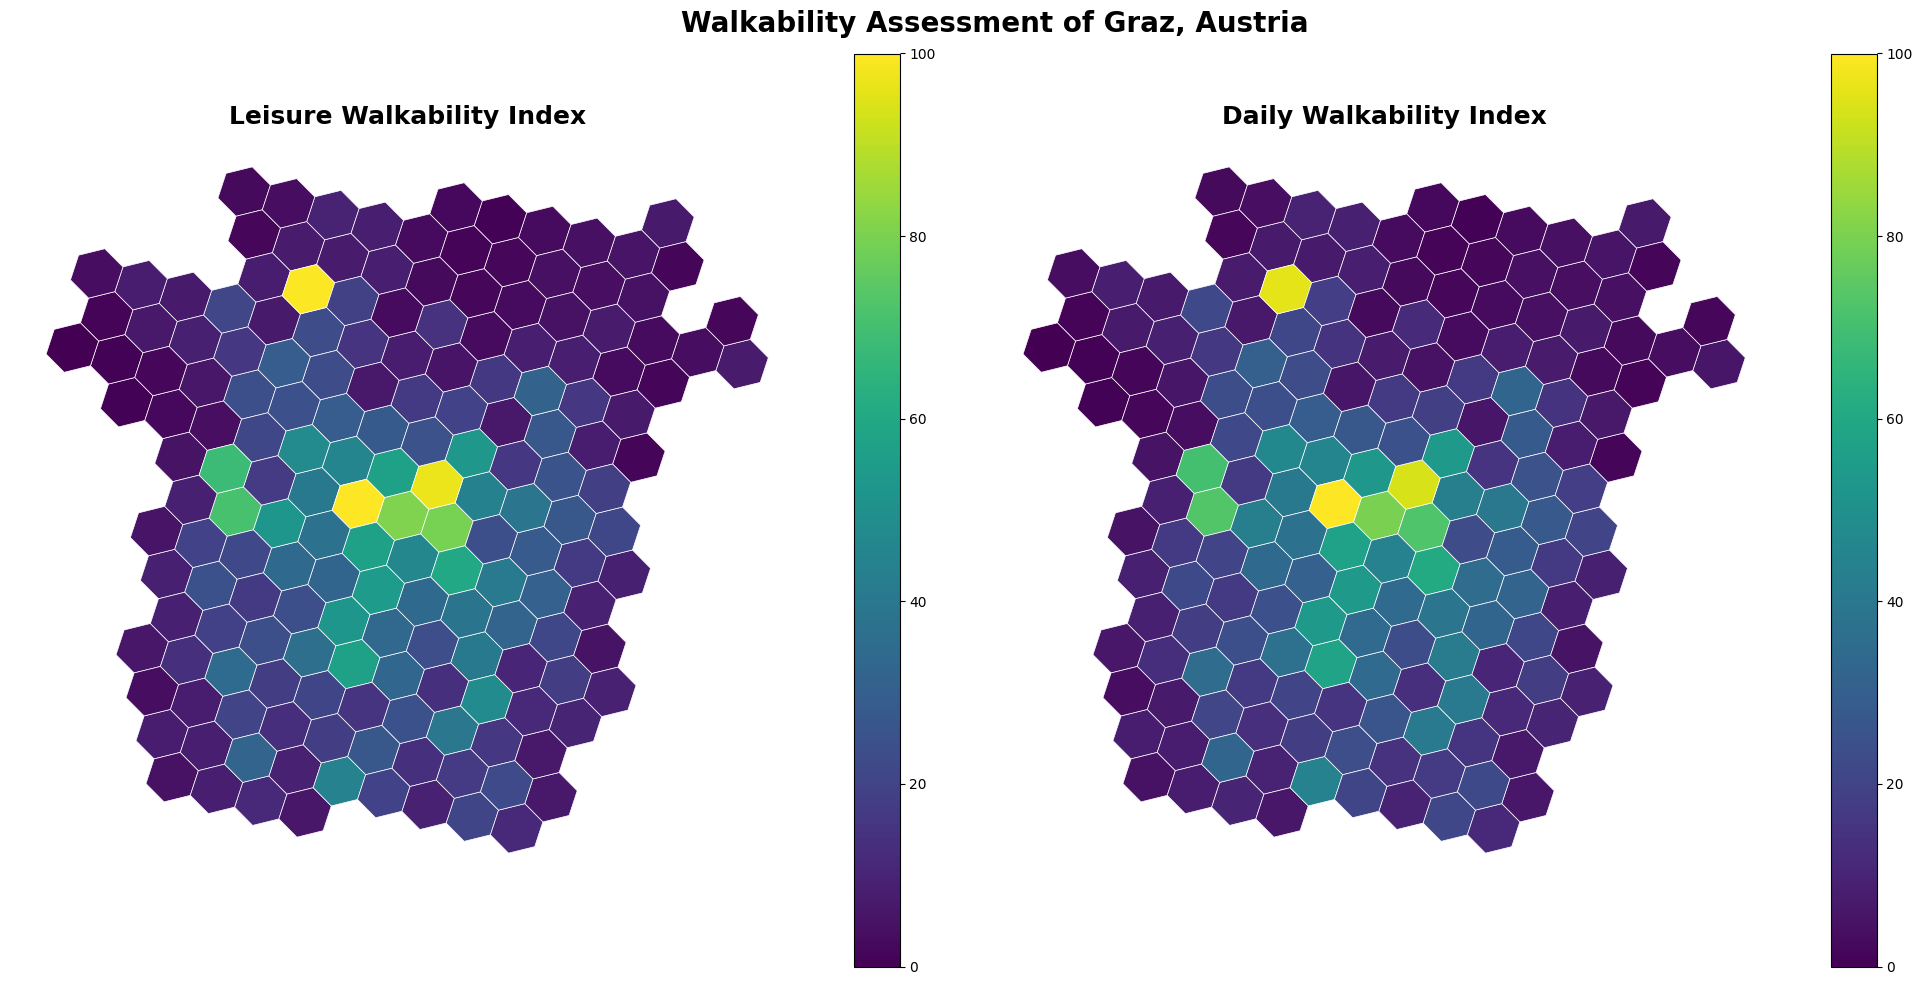

In [50]:
# Walkability Visualization for Graz
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Leisure Walkability
gdf_hex.plot(
    column='walkability_leisure',
    cmap='viridis',              
    linewidth=0.5,
    edgecolor='white',
    legend=True,
    ax=axes[0],
    vmin=0,
    vmax=100
)
axes[0].set_title('Leisure Walkability Index', fontsize=18, fontweight='bold')
axes[0].axis('off')

# Daily Walkability
gdf_hex.plot(
    column='walkability_daily',
    cmap='viridis',              
    linewidth=0.5,
    edgecolor='white',
    legend=True,
    ax=axes[1],
    vmin=0,
    vmax=100
)
axes[1].set_title('Daily Walkability Index', fontsize=18, fontweight='bold')
axes[1].axis('off')

plt.suptitle('Walkability Assessment of Graz, Austria', 
             fontsize=20, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

In [51]:
gdf_for_kepler = gdf_hex.to_crs("EPSG:4326").copy()

# Keep only relevant columns
cols_keep = [
    "h3_cells", "name", "geometry",
    "walkability_leisure", "walkability_daily",
    "green_blue_pct", "pop_density", "slope_deg"
]
gdf_for_kepler = gdf_for_kepler[cols_keep]

# --- Map 1: Walkability Leisure ---
map_leisure = KeplerGl(height=600)
map_leisure.add_data(data=gdf_for_kepler, name="Graz Walkability Leisure")
map_leisure  

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Graz Walkability Leisure': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16…

In [52]:
# --- Map 2: Walkability Daily ---
map_daily = KeplerGl(height=600)
map_daily.add_data(data=gdf_for_kepler, name="Graz Walkability Daily")
map_daily 

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Graz Walkability Daily': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, …